In [1]:
import torch

from rqvae.rqvae_data import get_data

df = get_data()

In [2]:
embs = torch.stack(df["embeddings"].tolist())

In [3]:
import json
from utils import DEVICE
from models.base import BaseModel

config = json.load(open("../configs/train/tiger_train_config.json"))

rqvae_train_config = json.load(open(config['rqvae_train_config_path']))
rq_vae_config = rqvae_train_config['model']
rq_vae_config['should_init_codebooks'] = False

rqvae_model = BaseModel.create_from_config(rq_vae_config).to(DEVICE)

rqvae_model.load_state_dict(torch.load(config['rqvae_checkpoint_path'], weights_only=True))
rqvae_model.eval()

ids = df.asin_numeric.tolist()

embs_dict = {"ids": torch.tensor(ids).to(DEVICE), "embeddings": embs.to(DEVICE)}

semantic_ids = list(rqvae_model.forward(embs_dict))

In [4]:
from rqvae.collisions import dedup

items_with_tuples = list(zip(df["asin"], df["title"].fillna("unknown"), semantic_ids))
items_with_tuples = dedup(items_with_tuples)

In [5]:
semantic_ids

[(86, 254, 243, 6),
 (44, 254, 243, 5),
 (224, 254, 243, 6),
 (61, 254, 243, 5),
 (80, 254, 243, 5),
 (224, 254, 243, 5),
 (141, 254, 84, 6),
 (68, 254, 84, 6),
 (1, 254, 243, 5),
 (224, 254, 243, 6),
 (74, 254, 84, 6),
 (244, 254, 243, 5),
 (73, 254, 243, 5),
 (109, 254, 243, 6),
 (127, 254, 243, 5),
 (73, 254, 243, 5),
 (19, 254, 243, 6),
 (230, 254, 243, 5),
 (184, 254, 12, 5),
 (143, 254, 243, 6),
 (25, 254, 243, 5),
 (106, 254, 243, 5),
 (199, 254, 243, 6),
 (19, 254, 243, 6),
 (230, 254, 243, 6),
 (63, 254, 243, 6),
 (150, 254, 243, 6),
 (77, 254, 243, 5),
 (144, 254, 243, 6),
 (249, 254, 243, 5),
 (135, 254, 243, 6),
 (109, 254, 243, 6),
 (223, 254, 243, 6),
 (146, 254, 243, 6),
 (242, 254, 243, 6),
 (109, 254, 243, 6),
 (19, 254, 243, 6),
 (144, 254, 243, 6),
 (63, 254, 243, 6),
 (46, 254, 243, 6),
 (175, 254, 243, 6),
 (19, 254, 243, 6),
 (109, 254, 243, 6),
 (9, 254, 243, 6),
 (68, 254, 243, 6),
 (254, 254, 243, 6),
 (122, 254, 12, 5),
 (109, 254, 243, 6),
 (3, 254, 243, 5),


In [11]:
from rqvae.rqvae_data import search_similar_items


for i in range(0, 10):
    sim = search_similar_items(items_with_tuples, (i,), 5)
    if len(sim) == 0:
        continue
    print(i)
    for asin, item, clust_tuple in sim:
        # if 'nail' in item.lower():
        print(f"{item=} {clust_tuple=}")

0
item='OPI Pink Shatter, Pink of Hearts 2011 - NLE58' clust_tuple=(0, 254, 243, 5, 112)
item='Laura Mercier Secret Concealer # 1 0.08oz' clust_tuple=(0, 254, 243, 5, 5)
item='Alterna Caviar Anti-Aging Replenishing Moisture Conditioner for Unisex, 8.5 Ounce' clust_tuple=(0, 254, 243, 5, 124)
item="L'oreal Professional Paris Absolut Repair Cellular Lactic Acid Shampoo, 8.45-Ounce Bottle" clust_tuple=(0, 254, 243, 5, 23)
item='NEW! Style Edit Conceal Spray 2 oz. BLACK/DARK BROWN (Conceal your gray between color services)' clust_tuple=(0, 254, 243, 5, 143)
1
item='BabyGanics Fine and Handy Foaming Hand Soap, Apple, 250 Ml, 8.45-Ounce (Pack of 2), Packaging May Vary' clust_tuple=(1, 254, 243, 5, 49)
item='TRESemme Thermal Creations Heat Tamer Spray, 8 Ounce (Pack of 6)' clust_tuple=(1, 254, 243, 5, 27)
item='Ardell Brow and Lash Growth Accelerator, 0.25-Ounce (Pack of 3)' clust_tuple=(1, 254, 243, 5, 26)
item='Maybelline New York Lash Stiletto Ultimate Length Washable Mascara, Brownish Bla

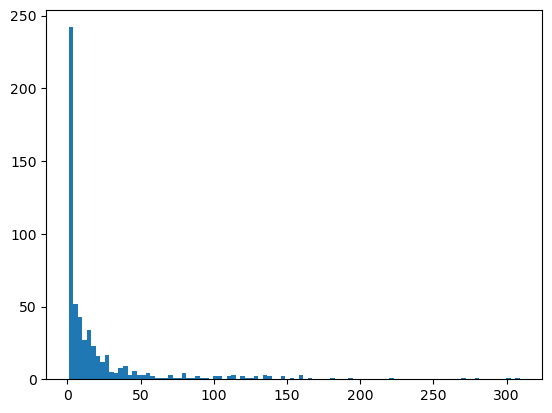

In [12]:
from collections import Counter
import matplotlib.pyplot as plt


plt.hist(Counter(item[-1][:-1] for item in items_with_tuples).values(), bins=100)
plt.show()

In [13]:
len(set(item[-1] for item in items_with_tuples))

12101

In [9]:
# from sklearn import preprocessing

# labels = df['asin']

# le = preprocessing.LabelEncoder()
# targets = le.fit_transform(labels)

# df['asin_numeric'] = targets

# torch.save(df, './all_data.pt')